# Pivot Tables

The pivot tables takes simple column-wise data as input. and groups the entries into a two-dimensional table that provides a multidimensional smmarizetion of the data.

We can think of pivot tables as essentially a **multidimensional** version of `GroupBy` aggregation.  
That is , we split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


## Pivot Tables by Hand


In [3]:
titanic.groupby('sex')['survived'].mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate(['mean']).unstack()

mean                    
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

## Pivot Table Syntax

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


### Multi-level pivot tables

In [6]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [7]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', index=['sex', age], columns='class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [8]:
# we can apply the same strategy when working with the columns
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', index=['sex', age], columns=['class', fare])

class                      First                             Second  \
fare            (-0.001, 14.454] (14.454, 512.329] (-0.001, 14.454]   
sex    age                                                            
female (0, 18]               NaN          0.909091         1.000000   
       (18, 80]              NaN          0.972973         0.880000   
male   (0, 18]               NaN          0.800000         0.000000   
       (18, 80]              0.0          0.391304         0.098039   

class                                        Third                    
fare            (14.454, 512.329] (-0.001, 14.454] (14.454, 512.329]  
sex    age                                                            
female (0, 18]           1.000000         0.714286          0.318182  
       (18, 80]          0.914286         0.444444          0.391304  
male   (0, 18]           0.818182         0.260870          0.178571  
       (18, 80]          0.030303         0.125000          0.192308

### Additional pivot table options

The full `pivot_table()` signature is as follow:  
```python
titanic.pivot_table(  
    values=None,  
    index=None,  
    columns=None,  
    aggfunc='mean',  
    fill_value=None,  
    margins=False,  
    dropna=True,  
    margins_name='All',  
)
```

The `aggfunc` keyword controls what type of aggregation is applied, which is `mean` by default.As in the GroupBy, the aggregation specification can be a string representing one of serveral common choices.(e.g., `sum`, `mean`, `count`...) or a function that implements an aggregation(e.g., `np.sum()`...)  
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options


In [9]:
def sum_func(x):
    return np.sum(x)+1

# Notice here that we've omitted the `value` keyword,
# when specifying a mapping for aggfunc, this is determined automatically
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum_func, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       92     71    73
male     67.226127  19.741782  12.661633       46     18    48

In [10]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

If we want to compute totals along each grouping, it can be done via `margins` keyword.(in probiblity theory, it is named **edge distribution rate**)  



In [11]:
titanic.pivot_table(values='survived',
                    index='sex', columns='class', margins=True)


class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here the margin label is `all`, we can specify the `margins_name` keyword to change the margin label

In [12]:
titanic.pivot_table('survived', index='sex', columns='class', 
                    margins=True, margins_name='margins distribution rate')

class,First,Second,Third,margins distribution rate
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
margins distribution rate,0.629630,0.472826,0.242363,0.383838


## Example: Birthrate Data

In [13]:
births = pd.read_csv('data/births.csv')

In [14]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


First let's add a decade column, and take a look at male and female births as a function of decade

In [46]:
births['decade'] = 10* (births['year'] // 10)
births.pivot_table(values='births', index=decade, columns='gender')

year


We immediately see the male births outnumber female births in every decade

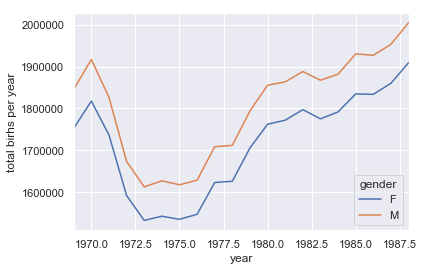

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
births.pivot_table('births', index='year', columns='gender', aggfunc=sum).plot()
plt.ylabel('total birhs per year')
plt.show()

### Further data exploration

Cleaning the data via robust **$\sigma$-clipping opertion**



In [48]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]  # the sample's mean
sig = 0.74 * (quartiles[2] - [quartiles[0]])

In [49]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Next, set `day` column to integers, it had been a float previously

In [50]:
births['day'] = births['day'].astype(int)

In [51]:
births.head()

,year,month,day,gender,births,dayofweek,decade
1969-01-01,1969,1,1,F,4046,2,1960
1969-01-01,1969,1,1,M,4440,2,1960
1969-01-02,1969,1,2,F,4454,3,1960
1969-01-02,1969,1,2,M,4548,3,1960
1969-01-03,1969,1,3,F,4548,4,1960


Finally we can combine the day, month and year to create a Data index

In [52]:
# 19690101
births.index = pd.to_datetime(10000 * births.year + 
                              100 * births.month + 
                              births.day, format='%Y%m%d')
births['dayofweek'] = births.index.dayofweek

In [53]:
import matplotlib.pyplot as plt
import matplotlib as mpl
births.head()

,year,month,day,gender,births,dayofweek,decade
1969-01-01,1969,1,1,F,4046,2,1960
1969-01-01,1969,1,1,M,4440,2,1960
1969-01-02,1969,1,2,F,4454,3,1960
1969-01-02,1969,1,2,M,4548,3,1960
1969-01-03,1969,1,3,F,4548,4,1960


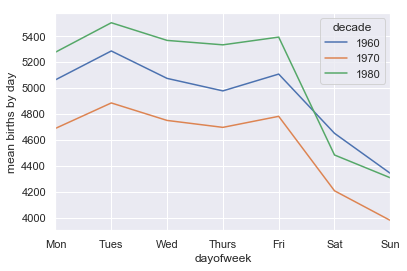

In [58]:
births.pivot_table('births', index='dayofweek', columns='decade'
                  , aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Plot the mean number of births by the day of the year

In [61]:
births.head()

,year,month,day,gender,births,dayofweek,decade
1969-01-01,1969,1,1,F,4046,2,1960
1969-01-01,1969,1,1,M,4440,2,1960
1969-01-02,1969,1,2,F,4454,3,1960
1969-01-02,1969,1,2,M,4548,3,1960
1969-01-03,1969,1,3,F,4548,4,1960


In [69]:
births_by_day = births.pivot_table('births',
                                   index=[births.index.month, births.index.day])
births_by_day.head()


births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [75]:
births_by_day.index = [pd.datetime(2012, month, day)
                       for (month, day) in births_by_day.index]
births_by_day.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


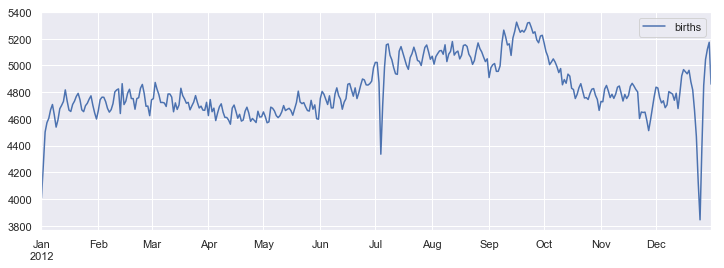

In [76]:
fig, ax = plt.subplots(figsize=(12,4))
births_by_day.plot(ax=ax)